Workflow:
- Import libraries
- Write code for Generator class
- Load data
- Load pretrained generator
- Load Inception model
- Play with multivariate normal distribution
- Write utility functions for calculating frechet distance
- Compute features
- Compute frechet distance
- Visualizing pairwise multivariate distributions of inception features

In [1]:
import torch
from torch import nn

from torch.utils.data import DataLoader
from torchvision.datasets import CelebA
from torchvision import transforms
from torchvision.utils import make_grid

from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
torch.manual_seed(0)

## Challenges With Evaluating GANs

#### Loss is Uninformative of Performance
One aspect that makes evaluating GANs challenging is that the loss tells us little about their performance. Unlike with classifiers, where a low loss on a test set indicates superior performance, a low loss for the generator or discriminator suggests that learning has stopped.


#### No Clear Non-human Metric
If you define the goal of a GAN as "generating images which look real to people" then it's technically possible to measure this directly: [you can ask people to act as a discriminator](https://arxiv.org/abs/1904.01121). However, this takes significant time and money so ideally you can use a proxy for this. There is also no "perfect" discriminator that can differentiate reals from fakes - if there were, a lot of machine learning tasks would be solved ;)

In this notebook, I will implement Fréchet Inception Distance, one method which aims to solve these issues.

## Generator

In [7]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (CelebA is rgb, so 3 is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_chan=3, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 8),
            self.make_gen_block(hidden_dim * 8, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN;
        a transposed convolution, a batchnorm (except in the final layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor,
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)

def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples, z_dim, device=device)

## Loading the Dataset

In [5]:
z_dim = 64
image_size = 299
device = 'cuda'
downloaded = True

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

if downloaded:
  data = torch.Tensor(np.load('/content/fid_images_tensor.npz', allow_pickle=True)['arr_0'])
  dataset = torch.utils.data.TensorDataset(data, data)
else:
  dataset = CelebA(".", download=True, transofrm=transform)

## Loading the Pre-trained Model


In [9]:
gen = Generator(z_dim).to(device)
gen.load_state_dict(torch.load(f'/content/pretrained_celeba.pth',
                               map_location=torch.device(device))['gen'])
gen.eval()

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(64, 512, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Sequential(
      (0): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2

## Inception-v3 Network
Inception-V3 is a neural network trained on [ImageNet](http://www.image-net.org/) to classify objects. ImageNet has over 1 million images to train on. As a result, Inception-V3 does a good job detecting features and classifying images. Here, I load Inception-V3 as `inception_model`.

In [13]:
from torchvision.models import inception_v3
inception_model = inception_v3(pretrained=False)
inception_model.load_state_dict(torch.load("/content/inception_v3_google-1a9a5a14.pth"))
inception_model.to(device)
inception_model = inception_model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


## Fréchet Inception Distance

Fréchet Inception Distance (FID) was proposed as an improvement over Inception Score and still uses the Inception-v3 network as part of its calculation. However, instead of using the classification labels of the Inception-v3 network, it uses the output from an earlier layer—the layer right before the labels. This is often called the feature layer. Research has shown that deep convolutional neural networks trained on difficult tasks, like classifying many classes, build increasingly sophisticated representations of features going deeper into the network. For example, the first few layers may learn to detect different kinds of edges and curves, while the later layers may have neurons that fire in response to human faces.

In [14]:
# To replace the fully connected layer with an identity layer:
inception_model.fc = nn.Identity()

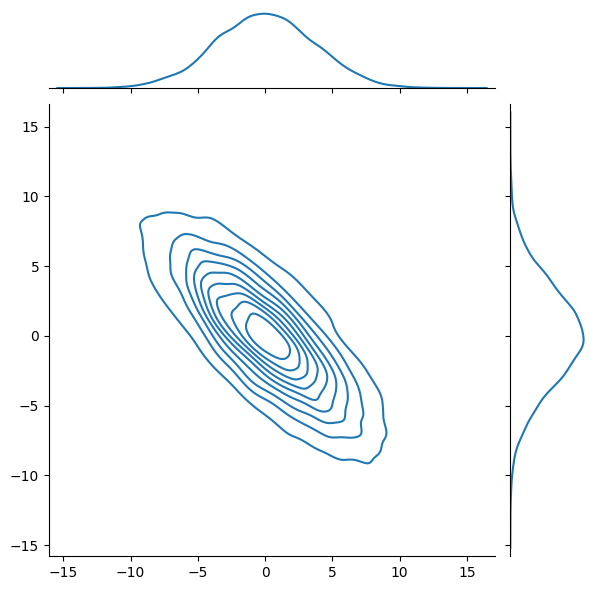

In [22]:
# Playing with Multivariate Normal Distributions
from torch.distributions import MultivariateNormal
import seaborn as sns
mean = torch.Tensor([0, 0])
covariance = torch.Tensor(
    [[13, -10],
     [-10, 13]])
independent_dist = MultivariateNormal(mean, covariance)
samples = independent_dist.sample((10000,))

res = sns.jointplot(x=samples[:, 0], y=samples[:, 1], kind="kde")
plt.show()

In [23]:
import scipy
def matrix_sqrt(x):
  y = x.cpu().detach().numpy()
  y = scipy.linalg.sqrtm(y)
  return torch.Tensor(y.real, device=x.device)

In [28]:
def frechet_distance(mu_x, mu_y, sigma_x, sigma_y):
  '''
  Parameters:
    mu_x: the mean of the first Gaussian, (n_features)
    mu_y: the mean of the second Gaussian, (n_features)
    sigma_x: the covariance matrix of the first Gaussian, (n_features, n_features)
    sigma_y: the covariance matrix of the second Gaussian, (n_features, n_features)
  '''
  return (torch.norm(mu_x - mu_y) ** 2) \
     + torch.trace(sigma_x + sigma_y - 2 * matrix_sqrt(sigma_x @ sigma_y))

## Putting it all together!

In [30]:
# Preprocessing the image, needed for Inception-v3
def preprocess(img):
  img = torch.nn.functional.interpolate(img, size=(299, 299), mode='bilinear', align_corners=False)
  return img

In [32]:
# Finding covariance from distribution
import numpy as np
def get_covariance(features):
  return torch.Tensor(np.cov(features.detach().numpy(), rowvar=False))

In [33]:
# Getting both distributions
fake_features_list = []
real_features_list = []

gen.eval()
n_samples = 512  # Total samples
batch_size = 4  # Samples per iteration

dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True
)

cur_samples = 0
with torch.no_grad(): # You don't need to calculate gradients here, so you do this to save memory
  try:
    for real_example, _ in tqdm(dataloader, total=n_samples // batch_size): # Go by batch
      real_samples = real_example
      real_features = inception_model(real_samples.to(device)).detach().to('cpu') # Move features to CPU
      real_features_list.append(real_features)

      fake_samples = get_noise(len(real_example), z_dim).to(device)
      fake_samples = preprocess(gen(fake_samples))
      fake_features = inception_model(fake_samples.to(device)).detach().to('cpu')
      fake_features_list.append(fake_features)
      cur_samples += len(real_samples)
      if cur_samples > n_samples:
        break
  except:
      print("Error in loop")

  0%|          | 0/128 [00:00<?, ?it/s]

In [34]:
# Computing properties for distributions
fake_features_all = torch.cat(fake_features_list)
real_features_all = torch.cat(real_features_list)

mu_fake = fake_features_all.mean(dim=0)
mu_real = real_features_all.mean(dim=0)
sigma_fake = get_covariance(fake_features_all)
sigma_real = get_covariance(real_features_all)

In [35]:
# Computing Frechet Distance
with torch.no_grad():
    print(frechet_distance(mu_real, mu_fake, sigma_real, sigma_fake).item())

138.5493621826172


Model gets a pretty high FID, likely over 30. Since lower is better, and the best models on CelebA get scores in the single-digits, there's clearly a long way to go with this model.

## Visualizing pairwise multivariate distributions of inception features

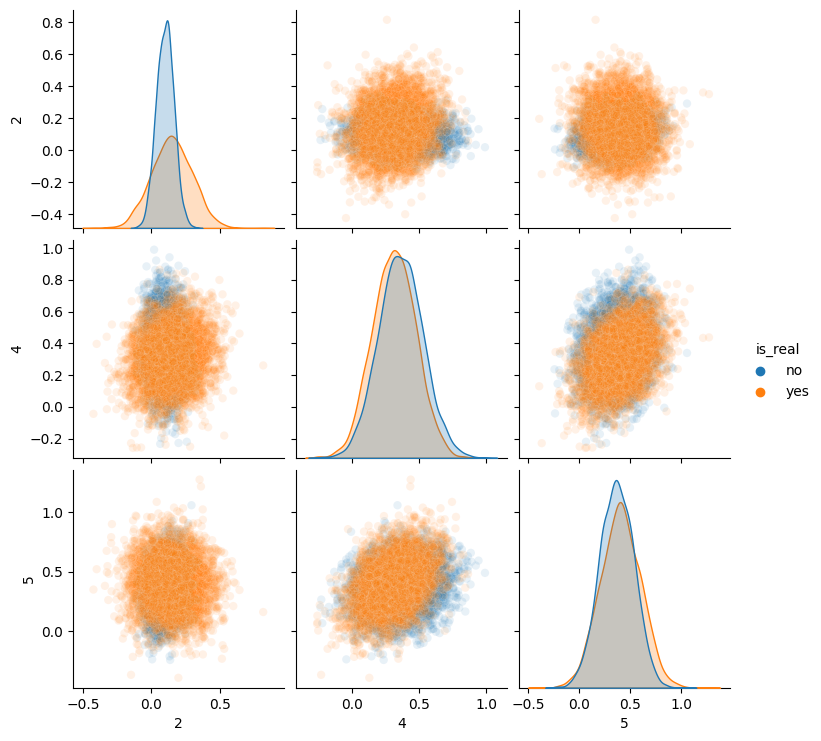

In [36]:
indices = [2, 4, 5]
fake_dist = MultivariateNormal(mu_fake[indices], sigma_fake[indices][:, indices])  # this distribution is of len(indices) no. of variables
fake_samples = fake_dist.sample((5000,))
real_dist = MultivariateNormal(mu_real[indices], sigma_real[indices][:, indices])
real_samples = real_dist.sample((5000,))

import pandas as pd
df_fake = pd.DataFrame(fake_samples.numpy(), columns=indices)
df_real = pd.DataFrame(real_samples.numpy(), columns=indices)
df_fake["is_real"] = "no"
df_real["is_real"] = "yes"
df = pd.concat([df_fake, df_real])
sns.pairplot(data = df, plot_kws={'alpha': 0.1}, hue='is_real')
plt.show()

More on pair plot: https://www.youtube.com/watch?v=b7JuBsswDlo&ab_channel=AppliedAICourse

In [44]:
df_fake

,2,4,5,is_real
0,0.147913,0.516999,0.363120,no
1,0.101794,0.412957,0.368604,no
2,0.096554,0.446063,0.216962,no
3,0.096495,0.390238,0.492421,no
4,0.078027,0.330564,0.343728,no
...,...,...,...,...
4995,0.088069,0.348350,0.268717,no
4996,0.181961,0.344481,0.506590,no
4997,0.123689,0.198214,0.312337,no
4998,0.120291,0.306305,0.191761,no
